In [1]:
import exponential_new_3desc as exponential_new
import numpy as np
import pandas as pd
from cutoffs_new import Polynomial
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
turbs = ["Siemens"] *2
turbs_3 = ["Siemens"] *3
nl=exponential_new.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":5.3, "offset": 1.},
                  {"type":"G4", "elements":"Siemens","eta":5., "gamma":4., "zeta":1.0},
                  {"type":"G6", "elements":"Siemens","eta":2., "gamma":0.5, "zeta":1.0}
                 ]}

symbol="Siemens"
dataset_pos=np.empty(shape=(0, 2))
dataset_fp=np.empty(shape=(0, 3))
dataset_ws=np.empty(shape=(0, 1))

In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 8])
    plt.xlabel('Epoch')
    plt.ylabel('Error [ref_wind_speed]')
    plt.legend()
    plt.grid(True)

In [3]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [4]:
three_turb_dataset = pd.read_csv('three_turbine_dataset.csv', index_col=0)
for i in range(360):
    id_dataset = three_turb_dataset.loc[three_turb_dataset['ID'] == i].reset_index(drop=True)
    position = np.array([[id_dataset.at[0,"X_coord"],id_dataset.at[0,"Y_coord"]],[id_dataset.at[1,"X_coord"],id_dataset.at[1,"Y_coord"]],[id_dataset.at[2,"X_coord"],id_dataset.at[2,"Y_coord"]]])
    ws = np.array([[id_dataset.at[0,"Ref_Wind_Speed"]], [id_dataset.at[1,"Ref_Wind_Speed"]], [id_dataset.at[2,"Ref_Wind_Speed"]]])
    neigh=nl.calculate(turbs_3,position)
    finpr=exponential_new.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
    fp=finpr.calculate(turbs_3,position,neigh,symbol)
    fp=np.array(fp)
    dataset_pos=np.append(dataset_pos,position,axis=0)
    dataset_fp=np.append(dataset_fp,fp,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)

In [5]:
two_turb_dataset = pd.read_csv('two_turbine_dataset.csv', index_col=0)
for distance in sorted(set(two_turb_dataset["Spacing"])):
    for angle in sorted(set(two_turb_dataset["Wind_angle"])):
        #print(distance,angle)
        id_dataset = two_turb_dataset[(two_turb_dataset.Wind_angle==angle) & (two_turb_dataset.Spacing==distance)].reset_index(drop=True)
        #print(id_dataset)
        if id_dataset.empty:
            continue
        ws=np.array([[id_dataset.at[0,'Ref_Wind_Speed']],[id_dataset.at[1,'Ref_Wind_Speed']]])
        #print(ws)
        position=np.array([[0., 0.], [((distance)*np.cos(np.deg2rad(270-angle))),((distance)*np.sin(np.deg2rad(270-angle)))]])
        neigh=nl.calculate(turbs,position)
        finpr=exponential_new.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
        fp=finpr.calculate(turbs,position,neigh,symbol)
        fp=np.array(fp)
        dataset_pos=np.append(dataset_pos,position,axis=0)
        dataset_fp=np.append(dataset_fp,fp,axis=0)
        dataset_ws=np.append(dataset_ws,ws,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)

In [6]:
dataset = pd.DataFrame(dataset, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])

In [7]:
dataset

,Fingerprint(G2),Fingerprint(G4),Fingerprint(G6),Ref_Wind_Speed
0,1.000000,1.000000,1.0,7.327663
1,1.000000,1.000000,1.0,7.369615
2,0.925499,0.779070,1.0,7.305162
3,1.000000,1.000000,1.0,7.300573
4,1.000000,1.000000,1.0,7.400468
...,...,...,...,...
1779,0.992108,0.983475,1.0,7.245134
1780,1.000000,1.000000,1.0,7.483274
1781,0.992108,0.985629,1.0,7.384614
1782,1.000000,1.000000,1.0,7.433140


In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [9]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
all_features = dataset.copy()

train_labels = train_features.pop('Ref_Wind_Speed')
test_labels = test_features.pop('Ref_Wind_Speed')
all_labels = all_features.pop('Ref_Wind_Speed')

In [10]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Fingerprint(G2),0.914853,0.168473
Fingerprint(G4),0.867763,0.233795
Fingerprint(G6),0.967354,0.119617
Ref_Wind_Speed,7.159370,0.525271


In [11]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[0.9148531  0.86776334 0.9673539 ]]


In [12]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                        

In [13]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=120)

CPU times: user 10.4 s, sys: 2.28 s, total: 12.7 s
Wall time: 7 s


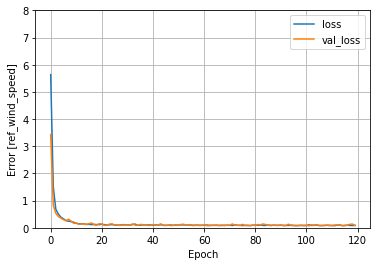

In [14]:
plot_loss(history)

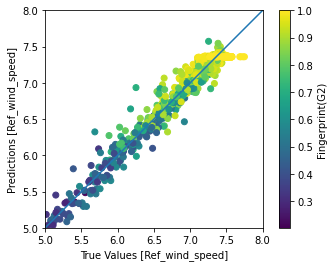

In [15]:
test_predictions = dnn_model.predict(test_features).flatten()
train_predictions = dnn_model.predict(train_features).flatten()
#test_predictions_0 = dnn_model.predict(test_features["Fingerprint(G2)"]==0).flatten()
#train_predictions_0 = dnn_model.predict(train_features["Fingerprint(G2)"]==0).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions,c=test_features["Fingerprint(G2)"])
plt.scatter(train_labels, train_predictions,c=train_features["Fingerprint(G2)"])
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G2)')
lims = [5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

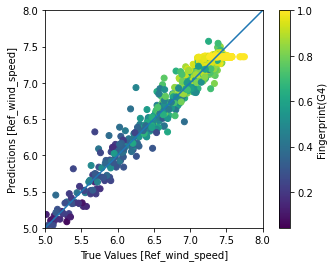

In [16]:
test_predictions = dnn_model.predict(test_features).flatten()
train_predictions = dnn_model.predict(train_features).flatten()
#test_predictions_0 = dnn_model.predict(test_features["Fingerprint(G4)"]==0).flatten()
#train_predictions_0 = dnn_model.predict(train_features["Fingerprint(G4)"]==0).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions,c=test_features["Fingerprint(G4)"])
plt.scatter(train_labels, train_predictions,c=train_features["Fingerprint(G4)"])
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G4)')
lims = [5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

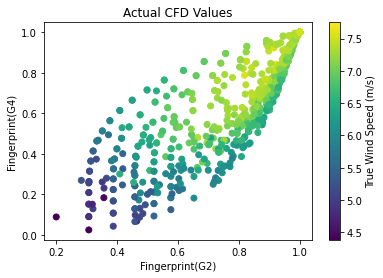

In [17]:

a = plt.axes
plt.scatter(test_features["Fingerprint(G2)"], test_features["Fingerprint(G4)"],c=np.abs(test_labels))
plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=np.abs(train_labels))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('True Wind Speed (m/s)')
#_ = plt.plot()

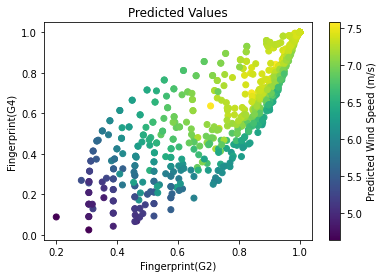

In [18]:
a = plt.axes
plt.scatter(test_features["Fingerprint(G2)"], test_features["Fingerprint(G4)"],c=np.abs(test_predictions))
plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=np.abs(train_predictions))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')
#_ = plt.plot()

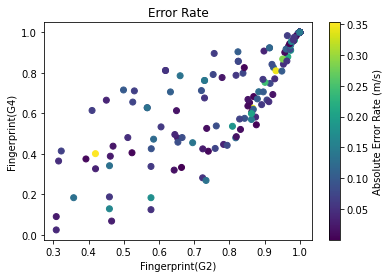

In [19]:
test_predictions = dnn_model.predict(test_features).flatten()
train_predictions = dnn_model.predict(train_features).flatten()
a = plt.axes
plt.scatter(test_features["Fingerprint(G2)"], test_features["Fingerprint(G4)"],c=np.abs(test_predictions-test_labels))
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=np.abs(train_predictions-train_labels))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Error Rate')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

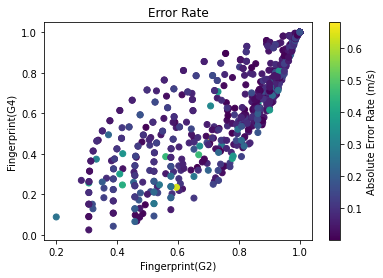

In [20]:
all_predictions = dnn_model.predict(all_features).flatten()
error_all=np.abs(all_predictions-all_labels)

a = plt.axes
plt.scatter(all_features["Fingerprint(G2)"], all_features["Fingerprint(G4)"],c=error_all)
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=np.abs(train_predictions-train_labels))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Error Rate')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

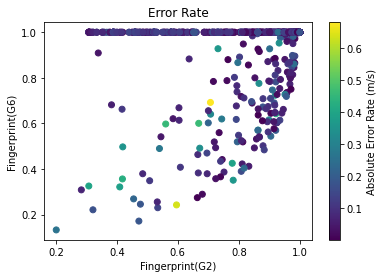

In [21]:
all_predictions = dnn_model.predict(all_features).flatten()
error_all=np.abs(all_predictions-all_labels)

a = plt.axes
plt.scatter(all_features["Fingerprint(G2)"], all_features["Fingerprint(G6)"],c=error_all)
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=np.abs(train_predictions-train_labels))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G6)')
plt.title('Error Rate')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

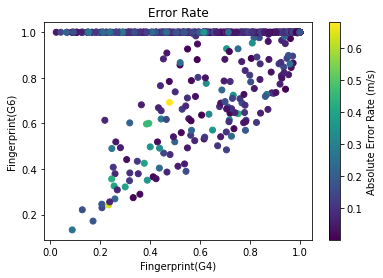

In [22]:
all_predictions = dnn_model.predict(all_features).flatten()
error_all=np.abs(all_predictions-all_labels)

a = plt.axes
plt.scatter(all_features["Fingerprint(G4)"], all_features["Fingerprint(G6)"],c=error_all)
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=np.abs(train_predictions-train_labels))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G4)')
plt.ylabel('Fingerprint(G6)')
plt.title('Error Rate')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(projection='3d')
ax.scatter(all_features["Fingerprint(G2)"], all_features["Fingerprint(G4)"], all_features["Fingerprint(G6)"], zdir='z', s=20, c=error_all, depthshade=True)

In [ ]:
import numpy
from mayavi.mlab import *

def test_points3d():


    x = all_features["Fingerprint(G2)"]
    y = all_features["Fingerprint(G4)"]
    z = all_features["Fingerprint(G6)"]
    s = error_all
    colorbar(orientation='vertical')
    xlabel('Fingerprint(G2)')
    ylabel('Fingerprint(G4)')
    zlabel('Fingerprint(G6)')
    return points3d(x, y, z, s, colormap="blue-red", scale_factor=0.05)
test_points3d()
#colorbar(object=all_labels, title="Points in Mayavi")
#view()
show()

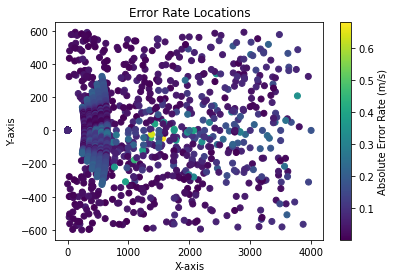

In [23]:
all_predictions = dnn_model.predict(all_features).flatten()
a = plt.axes
error_all=np.abs(all_predictions-all_labels)

plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all)
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=train_labels)
#plt.scatter(train_labels, train_predictions)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

In [24]:
arg=np.argsort(error_all)
error_all[arg]
pd.set_option("display.max_rows", None)
error_all[arg]

1744    0.000041
1134    0.000109
58      0.000181
73      0.000192
10      0.000255
103     0.000331
205     0.000465
1126    0.000557
1377    0.000725
16      0.000871
32      0.000940
953     0.001094
749     0.001245
13      0.001312
845     0.001348
956     0.001362
203     0.001365
816     0.001441
659     0.001447
458     0.001487
503     0.001512
1154    0.001733
295     0.001777
1146    0.001926
281     0.002171
813     0.002204
1001    0.002224
733     0.002232
1175    0.002239
272     0.002265
340     0.002343
1264    0.002440
834     0.002536
1013    0.002564
478     0.002618
837     0.002681
242     0.002690
889     0.002773
278     0.002776
1101    0.002812
787     0.002893
1781    0.002967
170     0.003078
822     0.003193
938     0.003204
259     0.003302
989     0.003345
233     0.003349
1359    0.003358
568     0.003413
1051    0.003463
1260    0.003487
94      0.003534
719     0.003535
499     0.003551
1268    0.003598
670     0.003624
274     0.003706
584     0.0038

In [ ]:
all_predictions = dnn_model.predict(all_features).flatten()
a = plt.axes
error_all=np.abs(all_predictions-all_labels)

plt.scatter(dataset_pos[arg[-20:],0], dataset_pos[arg[-20:],1],c=error_all[arg[-20:]])
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=train_labels)
#plt.scatter(train_labels, train_predictions)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()

In [ ]:
dataset_pos[523]
all_predictions[523]
#all_labels[523]

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
_ = plt.ylabel('Count')

In [ ]:
dnn_model.save('dnn_model')

In [ ]:
print(min(error),max(error))

In [ ]:
arg[30:]

In [ ]:
error_all[577:582]

In [ ]:
import matplotlib.cm as cm
plt.scatter(dataset['Fingerprint(G4)'],dataset['Fingerprint(G2)'], c=dataset['Ref_Wind_Speed'], s=10, cmap=cm.bwr)
cbar= plt.colorbar()
plt.xlabel('Fingerprint(G4)')
plt.ylabel('Fingerprint(G2)')
plt.show()

In [ ]:
np.mean(error_all)

In [ ]:
max(error_all)